## Introduction
This notebook contains the simulation of time series with linear and non-linear patterns. The time series are simulated based on a causal DAG, which defines the causal relationships in the tabular timeseries dataset. The generated data sets are then fed into PCMCI and PCMCI+ models as part of the Msc. Thesis Inferring Causal Relationships in Time Series using
various frameworks by Öykü Ece Ayaz.

The data simulator is manipulated based on Georg Velev's work.

In [1]:
pip install python-igraph

In [2]:
!pip install cgraph

In [3]:
!pip install graphviz


In [4]:
!apt-get install -y graphviz-dev



Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [5]:
!pip install pygraphviz

In [6]:
!pip install Cython==0.29.12 
import Cython

In [7]:
import pandas as pd
from random import randint, random
!pip install matplotlib==3.4.0
from matplotlib import pyplot as plt
import networkx as nx
!pip install numpy==1.21.1
!pip install dcor==0.5.3
!pip install scikit-learn==0.21

import sklearn as scikit_learn
import dcor
import numpy as np
!pip install --upgrade numpy
from scipy.special import expit as sigmoid
import igraph as ig
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import tensorflow
from statsmodels.tsa.arima_process import ArmaProcess
from tensorflow.python.keras import backend as K
from sklearn.metrics import recall_score,precision_score,f1_score
!pip install tigramite
from tigramite.pcmci import PCMCI
from tigramite import plotting as tp
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
import tigramite.tigramite_cython_code
import tigramite.data_processing as pp
import warnings
warnings.filterwarnings("ignore")

  Using cached numpy-1.21.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


  Using cached numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.7/dist-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'gpytorch'
  warnings.warn(str(e))


In [8]:
!pip3 install Cython==0.29.12 
import Cython

## Simulation of the causal DAG

In [9]:
def simulate_random_DAG(nodes,min_exogenous_nodes,edges,seed):
    import random
    random.seed(seed)
    
    G=None

    isolates=True

    while isolates:

        G = nx.DiGraph()
        #nodes=8
        for i in range(nodes):
            G.add_node(i)
            
        remaining_edges=edges
        
        

        while remaining_edges > 0:
            a = randint(0, nodes-1)
            b=a
            while b == a:
                b = randint(min_exogenous_nodes, nodes-1)
            
            if (a,b) not in list(G.edges):
                G.add_edge(a, b)
                if nx.is_directed_acyclic_graph(G):
                    remaining_edges -= 1
                else:
                    # we closed a loop!
                    G.remove_edge(a, b)
                

        number_isolates=len(list(nx.isolates(G)))
        if number_isolates==0:
            isolates=False
    return G

#Function for plotting the DAG:
def plot_DAG(G):
    pos = graphviz_layout(G, prog='dot')
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos,node_size=1000)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=20)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.show() 
    plt.close()
    
#Function for checking if graph is indeed a DAG:
def check_if_graph_is_DAG(G):
    import igraph as ig
    print('Graph is DAG according to netxworx: ',nx.is_directed_acyclic_graph(G))
    print('Graph is DAG according to igraph: ',ig.Graph.Adjacency(nx.convert_matrix.to_numpy_matrix(G).tolist()).is_dag(),'\n')
    
def time_series_with_seasonal_component(seasonal_interval,
                                        n,scale,seed):
    np.random.seed(seed)
    
    time = np.arange(-round(0.75*seasonal_interval),seasonal_interval-round(0.75*seasonal_interval),1,dtype=np.float32)
    seasonal_pattern = np.where(time > 0, np.sqrt(time)*3, np.tanh(time)*time)
    # Repeat the pattern several times
    seasonal_time_series =np.array([seasonal_pattern for i in range(0,round(n/seasonal_interval)+1)]).flatten()
    
    
    seasonal_time_series=seasonal_time_series[:n]+np.random.normal(scale=scale, size=n)
    
    return seasonal_time_series

#Function for simulating Trend Time Series:
def time_series_with_trend(trend_type,n,scale,seed):
    np.random.seed(seed)
    if trend_type=='up_trend':
        non_linear_trend = up_trend=(K.eval(tensorflow.keras.activations.elu(np.arange(-round(0.05*n),n-round(0.05*n),1,dtype=np.float32),alpha=5)*tensorflow.keras.activations.gelu(np.arange(-round(0.05*n),n-round(0.05*n),1,dtype=np.float32))))/100**2

    else: 
        non_linear_trend = down_trend=(K.eval(tensorflow.keras.activations.elu(np.flip(np.arange(-round(0.05*n),n-round(0.05*n),1,dtype=np.float32)),alpha=5)*tensorflow.keras.activations.gelu(np.flip(np.arange(-round(0.05*n),n-round(0.05*n),1,dtype=np.float32)))))/100**2




    noise = np.random.normal(scale=scale, size=n) #np.random.randn(250)*5
    trend_time_series=non_linear_trend+noise
    return trend_time_series

#Function for simulating stationary AR (2) process: 
def simulate_statinary_AR_signal(coefficients,n,scale,seed):
    np.random.seed(seed)
    #coefficients: for the AR(2) process
    #n: number of samples
    #scale: standard deviation of the noise
    
    if coefficients==None:
        first_coeff=np.random.uniform(-2, 2,1)
        keep_looping=True
        while keep_looping: 
            second_coeff=np.random.uniform(-1, 1,1)
            simulated_AR2_data=ArmaProcess([1,first_coeff,second_coeff], 
                                           [1,0,0]).generate_sample(nsample=n,sclae=scale)
            
            if run_stationary_tests(data=simulated_AR2_data,print_results=False)=='stationary':
                keep_looping=False
        print('First Coefficient: ',first_coeff,', Second Coefficient: ',second_coeff)
    else:
        simulated_AR2_data=ArmaProcess([1,coefficients[0],coefficients[1]], 
                                       [1,0,0]).generate_sample(nsample=n,scale=scale)
        if run_stationary_tests(data=simulated_AR2_data,print_results=False)=='not_stationary':
            raise ValueError('AR(2) Signal with pre-defined ar-params is not stationary!')

    return simulated_AR2_data

def run_stationary_tests(data,print_results):
    import warnings
    from statsmodels.tsa.stattools import adfuller
    warnings.filterwarnings("ignore")


    result = adfuller(data, autolag='AIC')
    if print_results==True:
        print('\033[1m','ADF Statistic:','\033[0m',result[0])
        print('\033[1m','p-value:','\033[0m',result[1])
        print('\033[1m','Critial Values:','\033[0m')
        for key, value in result[4].items():
            
            print(' ','\033[1m',key,': ','\033[0m',value)
    if result[1]>0.05:
        if print_results==True:
            print('According to ADF Test simulated AR signal:',' not stationary','\n')
        return 'not_stationary'
        
    else:
        if print_results==True:
            print('According to ADF Test simulated AR signal:',': stationary','\n')
        return 'stationary'
    
    
def compute_nonlinear_transformation(input_nodes,activation,low_weights,high_weights,self_gated_unit,seed):
    np.random.seed(seed)
    hidden = 100
    #n=1000
    pa_size=input_nodes.shape[1]
    W1 = np.random.uniform(low=low_weights, high=high_weights, size=[pa_size, hidden])
    W2 = np.random.uniform(low=low_weights, high=high_weights, size=hidden)
    if self_gated_unit==False:
        x =K.eval(activation(input_nodes@W1)) @ W2
    else:
        x =(K.eval(activation(input_nodes@W1))*(input_nodes@W1)) @ W2
    
    return x

## Linear Data Simulation
Firstly linear simulated data is generated using Tigramite's data processing class. 

In [10]:
# Linear Data Simulation
#reference: https://github.com/jakobrunge/tigramite/blob/master/tutorials/tigramite_tutorial_basics.ipynb

np.random.seed(42)     
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -2), 0.5), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5)],
                3: [((3, -1), 0.4)],
                4: [((0, -2), 0.3), ((3, -1), 0.9)]
                }
T = 1000     # time series length
data, true_parents_neighbors = pp.var_process(links_coeffs, T=T)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$', r'$X^4']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)

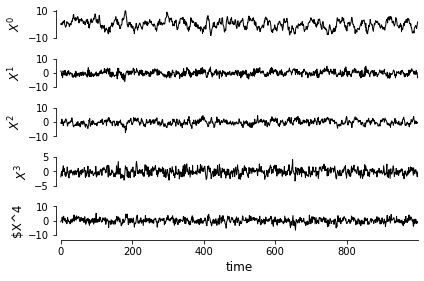

In [11]:
tp.plot_timeseries(dataframe); plt.show()


##PCMCI model with ParrCorr CI test

In [12]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

In [13]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 8 link(s):
    [pc_alpha = 0.4]
        ($X^1$ -1): max_pval = 0.00000, min_val = -0.673
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.626
        ($X^3$ -1): max_pval = 0.01219, min_val = -0.080
        ($X^4 -5): max_pval = 0.30259, min_val = -0.033
        ($X^4 -3): max_pval = 0.30968, min_val = -0.032
        ($X^0$ -8): max_pval = 0.35219, min_val = -0.030
        ($X^4 -6): max_pval = 0.36779, min_val =  0.029
        ($X^1$ -4): max_pval = 0.39301, min_val = -0.027

    Variable $X^1$ has 7 link(s):
    [pc_alpha = 0.5]
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.615
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.455
        ($X^2$ -4): max_pval = 0.13075, min_val = -0.048
        ($X^1$ 

In [14]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val = -0.621
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.556

    Variable $X^1$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.627
        ($X^1$ -2): pval = 0.00000 | qval = 0.00000 | val =  0.424

    Variable $X^2$ has 2 link(s):
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.422
        ($X^1$ -2): pval = 0.00000 | qval = 0.00000 | val =  0.421

    Variable $X^3$ has 1 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.394

    Variable $X^4 has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.674
        ($X^0$ -2): pval = 0.00000 | qval = 0.00000 | val =  0.363


In [15]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

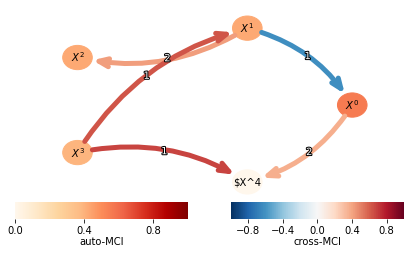

In [16]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

## Nonlinear Data Simulation and Outlier Injection
The simulation of the data is done in 2 parts: simulation of a causal DAG and simulation of tabular time series data based on the causal DAG. 

First, the simulation of the causal DAG is executed:

 Randomly simulated causal DAG: 


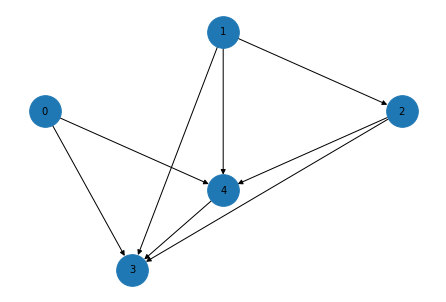

In [10]:
simulated_DAG=simulate_random_DAG(nodes=5,
                                 min_exogenous_nodes=2,
                                 edges=8,
                                 seed=150)
print('\033[1m','Randomly simulated causal DAG:','\033[0m')

plot_DAG(simulated_DAG)


The (exogenous) nodes without a parent node in the causal DAG:
- 0, 1<br>

The (endogenous) nodes with parent(s) in the causal DAG:
- 2: parents 1
- 3: parents 0 & 1 & 2 & 4
- 4: parents 0 & 1 & 2


In [11]:
adjacency_matrix=nx.convert_matrix.to_numpy_matrix(simulated_DAG)
print('\033[1m','Adjacency Matrix of the causal DAG:','\033[0m')
print(adjacency_matrix,'\n')

 Adjacency Matrix of the causal DAG: 
[[0. 0. 0. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]] 



First the exogeneous nodes 0 and 1 are simulated using signal with seasonal component and stationary AR signals:


 Column 0:   no Parent Nodes 



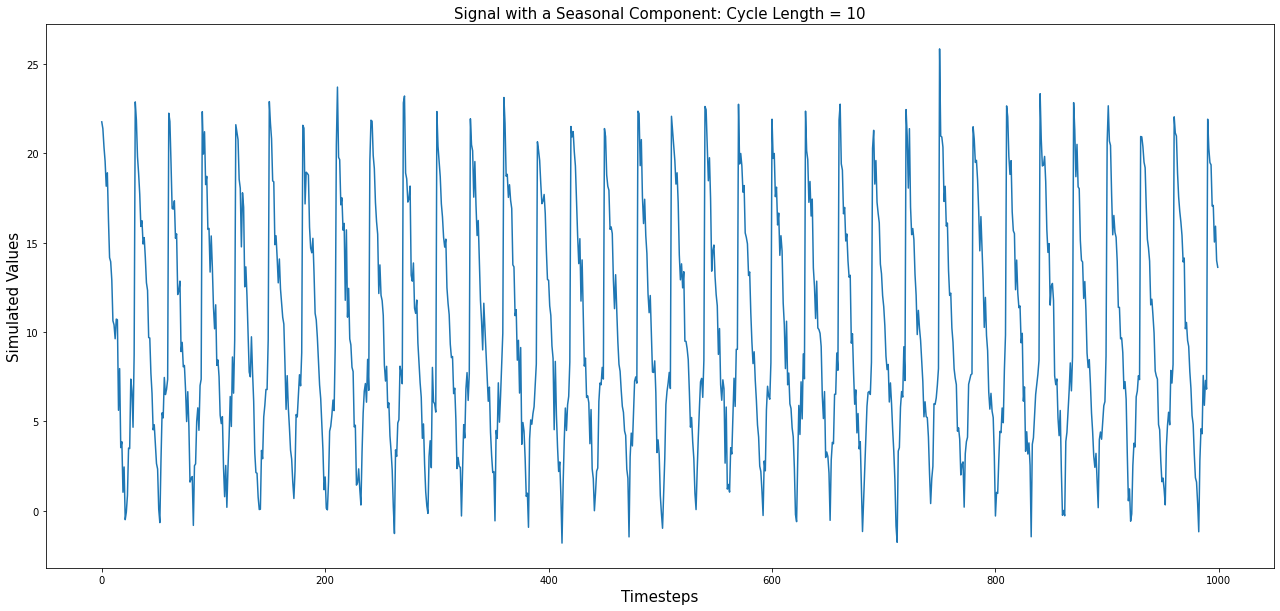

In [12]:
n=1000
X=np.zeros((n,5))
print('\033[1m','Column 0:','\033[0m',' no Parent Nodes','\n')
X[:,0]=time_series_with_seasonal_component(seasonal_interval=30,#seasonal_interval=10,
                                           n=n,
                                           scale=1.0, #scale=2.0
                                           seed=150)
plt.figure(figsize=(22,10))
plt.plot(X[:,0])
plt.title('Signal with a Seasonal Component: Cycle Length = 10',fontsize=15)
plt.ylabel('Simulated Values',fontsize=15)
plt.xlabel('Timesteps',fontsize=15)
plt.show()
plt.close()

 Column 1:  no Parent Nodes


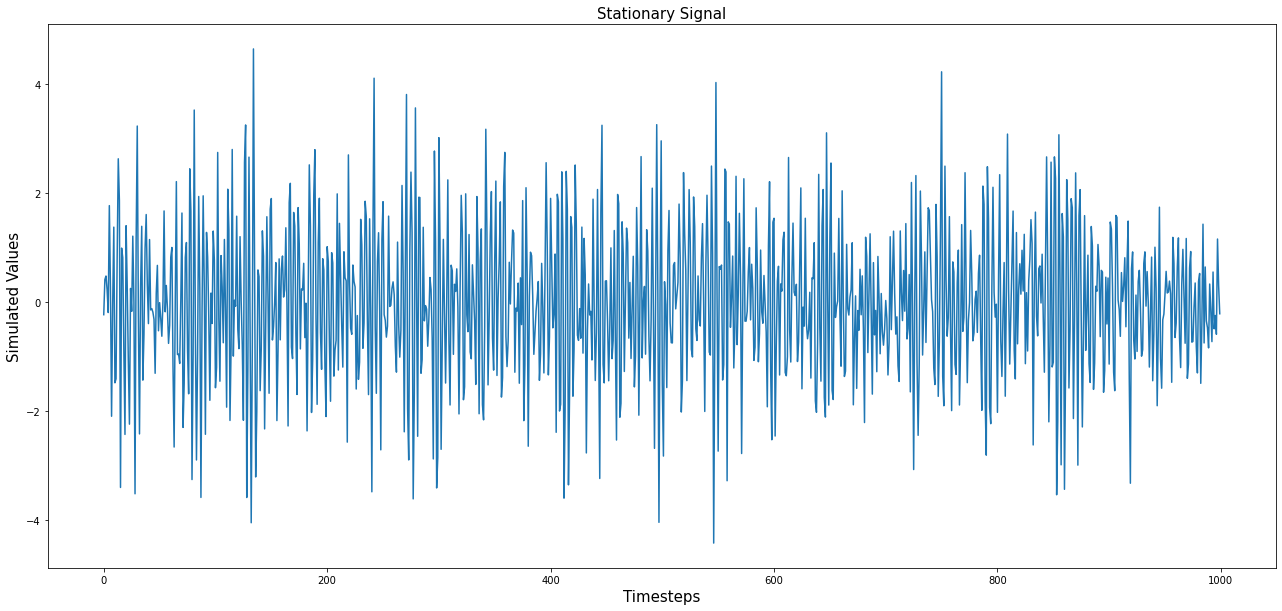

 ADF Statistic:  -19.079367324096303
 p-value:  0.0
 Critial Values: 
   1% :   -3.4369325637409154
   5% :   -2.8644462162311934
   10% :   -2.568317409920808
According to ADF Test simulated AR signal: : stationary 



In [20]:
n=1000
d=5

print('\033[1m','Column 1:','\033[0m','no Parent Nodes')#,' Signal with an Up-Trend','\n')
X[:,1]=simulate_statinary_AR_signal(coefficients=[0.10, 0.70], #coefficients=[0.20,0.55],
                                    n=n,
                                    scale=1.0,
                                    seed=150)


plt.figure(figsize=(22,10))
plt.plot(X[:,1])
plt.title('Stationary Signal',fontsize=15)
plt.ylabel('Simulated Values',fontsize=15)
plt.xlabel('Timesteps',fontsize=15)
plt.show()
plt.close()
test_result=run_stationary_tests(data=X[:,1],print_results=True)

Then the endogeneous variables are simulated using nonlinear activation functions:

 Column 2:   Parent Node 1 



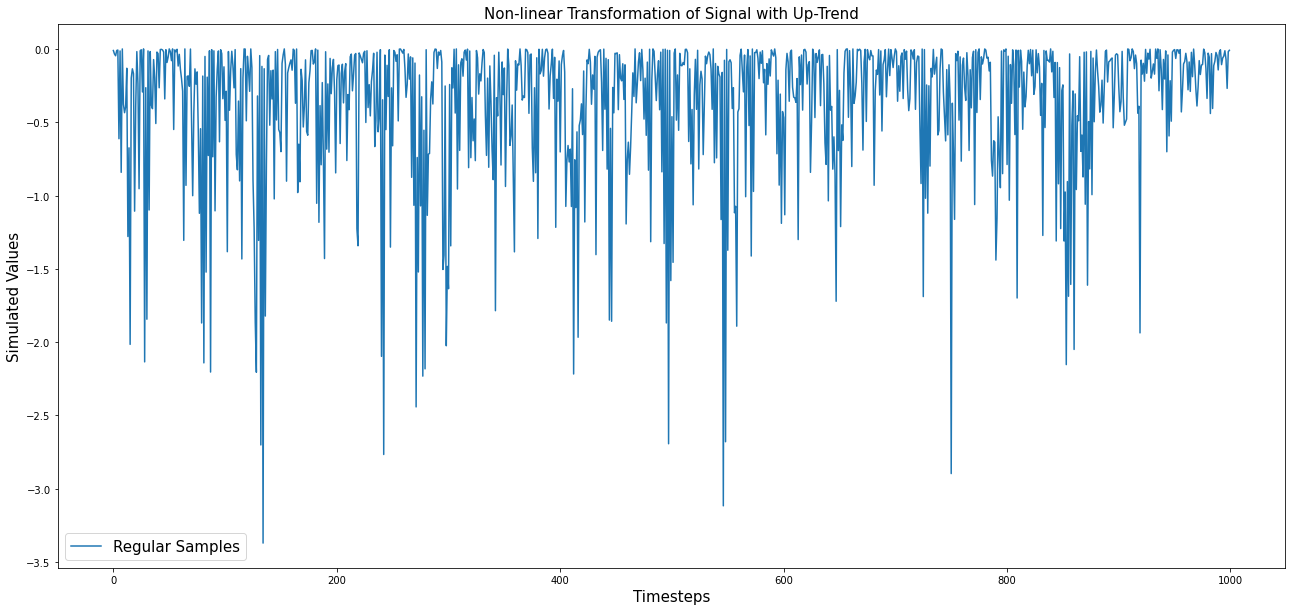

In [21]:
print('\033[1m','Column 2:','\033[0m',' Parent Node 1','\n')
X[:,2]=compute_nonlinear_transformation(input_nodes=X[:,[1]],
                                 activation=tensorflow.keras.activations.tanh, #activation=tensorflow.keras.activations.sigmoid
                                 low_weights=-0.3,#low_weights=-0.5,
                                 high_weights=0.1,#high_weights=0.2, 
                                 self_gated_unit=True,
                                 seed=150)




plt.figure(figsize=(22,10))
plt.plot(X[:,2])
plt.title('Non-linear Transformation of Signal with Up-Trend',fontsize=15)
plt.ylabel('Simulated Values',fontsize=15)
plt.xlabel('Timesteps',fontsize=15)
plt.legend(['Regular Samples','Contextual & Hybrid Outliers'],fontsize=15)
plt.show()
plt.close()

 Column :   Parent Nodes  



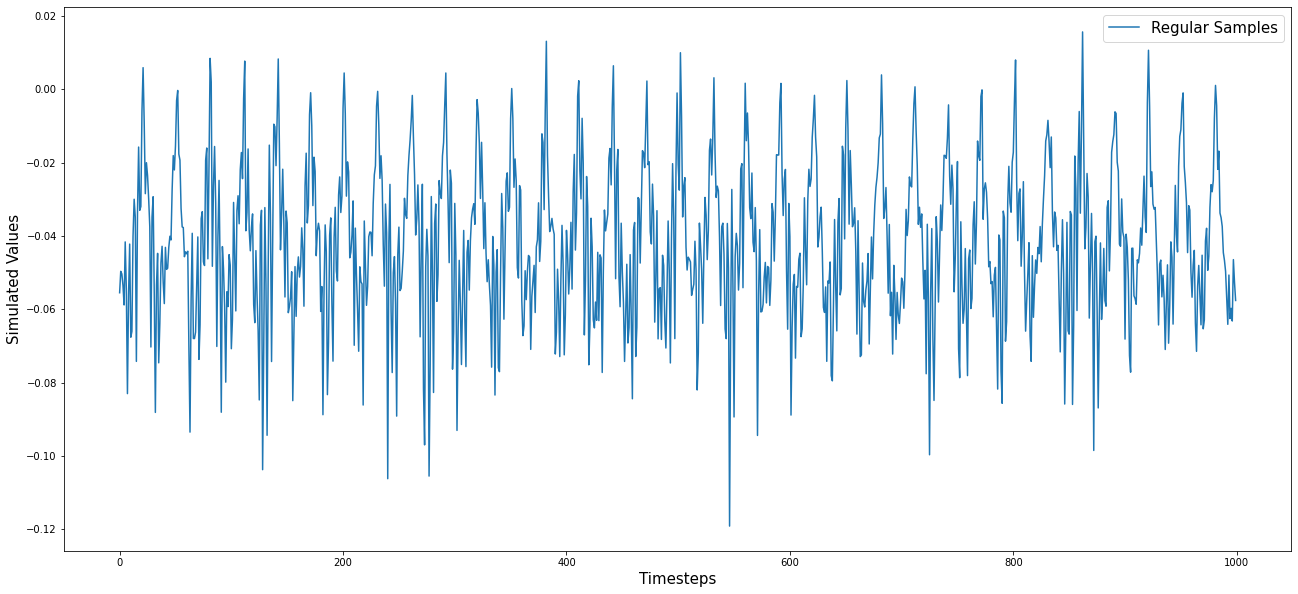

In [22]:
print('\033[1m','Column :','\033[0m',' Parent Nodes ','\n')
X[:,4]=compute_nonlinear_transformation(input_nodes=X[:,[0,1,2]],
                                 activation=tensorflow.keras.activations.gelu, #activation=tensorflow.keras.activations.softsign,
                                 low_weights=-0.05,
                                 high_weights=0.07,
                                 self_gated_unit=False,
                                 seed=150)



plt.figure(figsize=(22,10))
plt.plot(X[:,4])

plt.ylabel('Simulated Values',fontsize=15)
plt.xlabel('Timesteps',fontsize=15)
plt.legend(['Regular Samples','Contextual Outliers'],fontsize=15)
plt.show()
plt.close()

 Column 3:   Parent Nodes 0, 1, 2, 4 



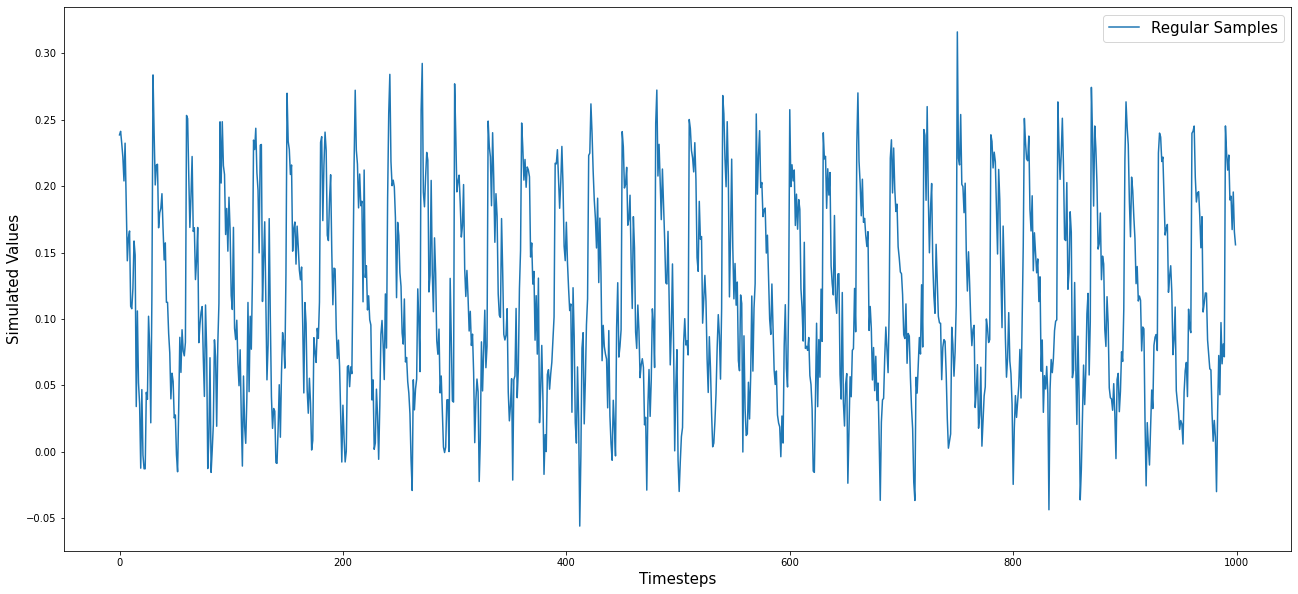

In [23]:
print('\033[1m','Column 3:','\033[0m',' Parent Nodes 0, 1, 2, 4','\n')

X[:,3]=compute_nonlinear_transformation(input_nodes=X[:,[0,1,2,4]],
                                 activation=tensorflow.math.sin, #activation=tensorflow.keras.activations.linear, 
                                 low_weights=-0.05,
                                 high_weights=0.03,
                                 self_gated_unit=False,
                                 seed=150)

plt.figure(figsize=(22,10))
plt.plot(X[:,3])

plt.ylabel('Simulated Values',fontsize=15)
plt.xlabel('Timesteps',fontsize=15)
plt.legend(['Regular Samples','Contextual Outliers'],fontsize=15)
plt.show()
plt.close()





## Tigramite Framework on Nonlinear Data
First PCMCI frameworks will be tested, using ParrCorr and CMIknn CI tests.

In [24]:
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$', r'$X^4$']
dataframe = pp.DataFrame(X, 
                         datatime = np.arange(len(X)), 
                         var_names=var_names)

**1. PCMCI with ParrCorr Independence Test**

In [26]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


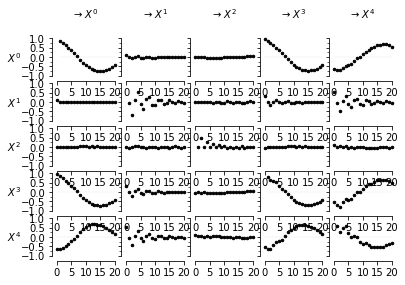

In [27]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':0.5}); plt.show()

In [28]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 9 link(s):
    [pc_alpha = 0.5]
        ($X^4$ -8): max_pval = 0.00000, min_val =  0.269
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.228
        ($X^4$ -1): max_pval = 0.00000, min_val = -0.185
        ($X^3$ -8): max_pval = 0.00000, min_val = -0.156
        ($X^0$ -8): max_pval = 0.00004, min_val = -0.130
        ($X^4$ -6): max_pval = 0.02416, min_val = -0.072
        ($X^4$ -3): max_pval = 0.04026, min_val =  0.065
        ($X^3$ -6): max_pval = 0.14089, min_val =  0.047
        ($X^2$ -8): max_pval = 0.43495, min_val = -0.025

    Variable $X^1$ has 5 link(s):
    [pc_alpha = 0.2]
        ($X^1$ -2): max_pval = 0.00000, min_val = -0.530
        ($X^1$ -4): max_pval = 0.00730, min_val =  0.086
        ($X^

In [29]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 19 link(s):
        ($X^3$  0): pval = 0.00000 | qval = 0.00000 | val =  0.930
        ($X^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.439
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.421
        ($X^0$ -8): pval = 0.00000 | qval = 0.00000 | val =  0.301
        ($X^3$ -8): pval = 0.00000 | qval = 0.00000 | val = -0.295
        ($X^4$ -8): pval = 0.00000 | qval = 0.00000 | val =  0.280
        ($X^4$ -1): pval = 0.00000 | qval = 0.00000 | val = -0.262
        ($X^4$ -7): pval = 0.00000 | qval = 0.00000 | val = -0.251
        ($X^1$ -3): pval = 0.00000 | qval = 0.00000 | val = -0.182
        ($X^0$ -6): pval = 0.00000 | qval = 0.00000 | val = -0.179
        ($X^1$ -8): pval = 0.00000 | qval = 0.00000 | val = -0.163
        ($X^0$ -3): pval = 0.00001 | qval = 0.00005 | val = -0.145
        ($X^3$ -3): pval = 0.00002 | qval = 0.00012 | val = -0.138
        ($X^4$ -3): pval = 0.00002 | qval = 0.00017 | 

In [30]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

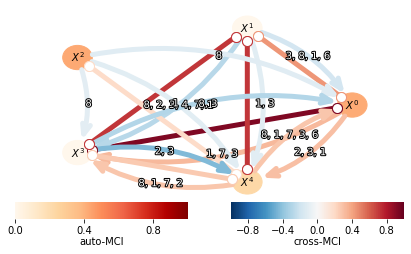

In [31]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

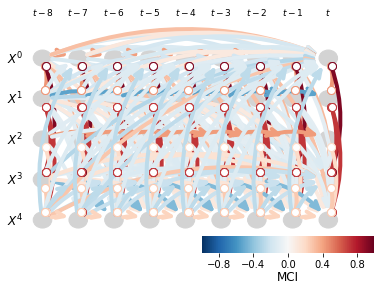

In [33]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

**2. PCMCI with CMIknn Independence test**

In [34]:
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=2)
results = pcmci_cmi_knn.run_pcmci(tau_max=2, pc_alpha=0.05)
pcmci_cmi_knn.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link ($X^0$ -1) --> $X^0$ (1/10):
    Subset 0: () gives pval = 0.00000 / val =  1.089
    No conditions of dimension 0 left.

    Link ($X^0$ -2) --> $X^0$ (2/10):
    Subset 0: () gives pval = 0.00000 / val =  0.884
    No conditions of dimension 0 left.

    Link ($X^1$ -1) --> $X^0$ (3/10):
    Subset 0: () gives pval = 0.73300 / val =  0.001
    Non-significance detected.

    Link ($X^1$ -2) --> $X^0$ (4/10):
    Subset 0: () gives pval = 0.62700 / val =  0.002
    Non-significance detected.

    Link ($X^2$ -1) --> $X^0$ (5/10):
    Subset 0: () gives pval = 0.41000 / val =  0.002
    Non-significance detected.

    Link ($X^2$ -2) --> $X^0$ (6/10):
    Subset 0: () gives pv

In [35]:
q_matrix = pcmci_cmi_knn.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
link_matrix = pcmci_cmi_knn.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

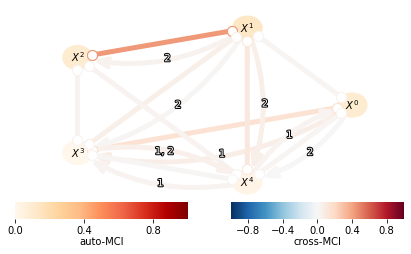

In [36]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

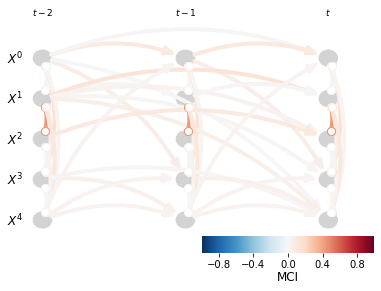

In [37]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

**3. PCMCI+ with CMIknn Independence test**

In [38]:
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=2)

In [39]:
tau_max = 3
pc_alpha = 0.01
pcmci_cmi_knn.verbosity = 2

results = pcmci_cmi_knn.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 3
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link ($X^0$ -1) --> $X^0$ (1/15):
    Subset 0: () gives pval = 0.00000 / val =  1.088
    No conditions of dimension 0 left.

    Link ($X^0$ -2) --> $X^0$ (2/15):
    Subset 0: () gives pval = 0.00000 / val =  0.882
    No conditions of dimension 0 left.

    Link ($X^0$ -3) --> $X^0$ (3/15):
    Subset 0: () gives pval = 0.00000 / val =  0.726
    No conditions of dimension 0 left.

    Link ($X^1$ -1) --> $X^0$ (4/15):
    Subset 0: () gives pval = 0.74900 / val =  0.001
    Non-significance detected.

    Link ($X^1$ -2) --> $X^0$ (5/15):
    Subset 0: () gives pval = 0.73300 / val =  0.001
    Non-significance detected.

    Link ($X^1$ -3) --> $X^0$ (6/15):
    Subset 0: () 

In [40]:
q_matrix = pcmci_cmi_knn.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
link_matrix = pcmci_cmi_knn.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

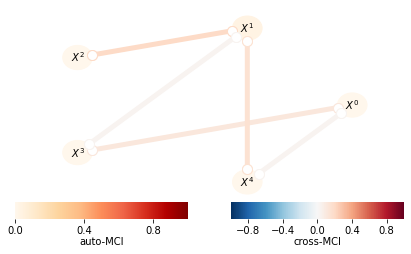

In [41]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

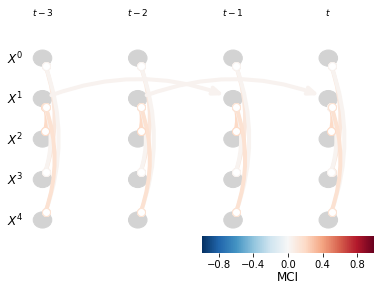

In [42]:
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()